In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 21 10:51:23 2023

@author: souchaud
"""

import os
import glob
import imageio
import numpy as np
import pandas as pd
import trackpy as tp
from tqdm import tqdm
# import functions_track_and_analyze as lib
import matplotlib.pyplot as plt
from IPython.display import display
import cv2
from skimage import util
# from joblib import Parallel, delayed

In [9]:
# Consolidated parameters
PARAMS = {
        # Préparation images
        'GaussianBlur': (31, 31), # (19, 19), #  (5, 5),
        'sigmaX': 10,
        'sigmaY': 10, 
        'threshold': 5, #12, # 3, # 10  # 40,
        'percentile': 10, #10,
        'lenght_study': 50, # Découpage de la manip en nombre de frale pour favoriser l'étude (performence ordi)
        'smoothing_size': None,
        'invert': True,
        'preprocess': True, 
        'characterize': True,
        'filter_before': None,
        'filter_after': None,
        # Paramètres Manip
        'pixel_size': 0.637,  # 1.2773, # en um
        'frame_interval': 15, # temps entre chaque frame
        'long_time': False,
        'max_frame': 340, # 340, #340 # Nombre de frame d'étude max.
        'min_frames': 150, #150, # Nombre de frame sur laquelle doit être suivie une cellule
        'topn': 120, # None, # Nombre de particules max à détecter

        # Détéction particules
        'diameter': 81, #51,  # 15, # Diamètres évalué des particules
        'max_displacement': 30, # 35, # 25, # Déplacement maximal des cellules entre deux images (en pixel)
        'search_range': 30, #  30, #  20 # même chose
        'minmass': 1000, #  Mass minimale mesurée des cellules
        'max_size': 30, # 25, # Taille maximum de la particule
        'separation': 100, # 9, # distance mimimanl pour séparé deux objets
        'noise_size': 3,  # 7, # 7, # taille des particules à exclure 
        'max_iterations': 15, # Nombre d'itérations max pour résoudre un sous-réseau (déterminer les trajectoires entre 2 cellules)
        'memory': 15, # Nombre de frame au dela de laquelle on oublie la cellule
        'engine': 'auto',

        # Format et chemins
        'remove_exts': ['.jpg', '.svg', 'hdf5', '.png'],   
        'data_dir': '/Users/souchaud/Desktop/A_Analyser/CytoOne_HL5_10x/',
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',
        # 'data_dir': '/Users/souchaud/Desktop/A_Analyser/NonT_SorC/',
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_longtime/'
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',´
        'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_new_param/'
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/NonT_SorC_longtime_New/'
        }

In [10]:
EXPERIMENT_NAMES = [f + '/mosaic/' for f in os.listdir(PARAMS['data_dir'])
                    if os.path.isdir(os.path.join(PARAMS['data_dir'], f))]
print(EXPERIMENT_NAMES)

['2023_12_07_ASMOT110_AX3_P0_x10_15x_CytoOne_HL5/mosaic/']


In [11]:
def compute_mean_speed(filtered):
    """
    Compute mean speed.

    Parameters
    ----------
    - filtered: DataFrame with tracked cells
    Returns
    - mean_speed: Mean speed of all particles
    - mean_speed_part: Mean speed per particle
    """
    dx = filtered.groupby('particle')['x'].diff()
    dy = filtered.groupby('particle')['y'].diff()
    displacement = np.sqrt(dx**2 + dy**2)
    duration = filtered.groupby('particle')['frame'].diff() * PARAMS['frame_interval']
    mean_speed = (displacement.sum() / duration.sum()) * PARAMS['pixel_size'] * 60
    instant_speed = displacement / duration
    mean_speed_part = instant_speed.groupby(filtered['particle']).mean() * PARAMS['pixel_size'] * 60
    return mean_speed, mean_speed_part


def clean_directory(dir_path):
    """Remove all files with the specified extensions in the directory."""
    for file in os.listdir(dir_path):
        if file.endswith(tuple(PARAMS['remove_exts'])):
            os.remove(os.path.join(dir_path, file))

In [12]:
def adjust_brightness_contrast(img, brightness=0, contrast=0):
    """ Ajuster la luminosité et le contraste d'une image """
    B = brightness / 100.0
    C = contrast / 100.0
    k = np.tan((45 + 44 * C) / 180 * np.pi)

    img = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [13]:
def process_experiment(exp_name, PARAMS):
    """Process a single experiment."""
    output_path = os.path.join(PARAMS['output_dir'], exp_name)
    os.makedirs(output_path, exist_ok=True)

    clean_directory(output_path)

    experiment_data_dir = os.path.join(PARAMS['data_dir'], exp_name)

    def extract_number(filename):
        # Extrait le numéro à partir du nom de fichier
        base_name = os.path.basename(filename)
        # Supprime l'extension et extrait le numéro
        number = int(base_name.split('_')[-1].split('.')[0])
        return number

    tiff_files = sorted(glob.glob(os.path.join(experiment_data_dir, "*.tif")), key=extract_number)

    # Use PARAMS dictionary to get the parameters
    frame_data = []
    frame_counter = 0
    boucle = []
    if PARAMS['long_time'] is False:
        if len(os.listdir(experiment_data_dir)) < PARAMS['max_frame']:
            nbr_frame_study_total = len(os.listdir(experiment_data_dir))
        else:
            nbr_frame_study_total = PARAMS['max_frame']
    else:
        nbr_frame_study_total = len(os.listdir(experiment_data_dir))

    lenght_study = PARAMS['lenght_study']
    if nbr_frame_study_total > lenght_study:
        number = lenght_study
        while number < nbr_frame_study_total:
            boucle.append(lenght_study)
            number += lenght_study
            if number > nbr_frame_study_total:
                boucle.append(nbr_frame_study_total - len(boucle) * lenght_study)
        nbr_frame_study = lenght_study
    else:
        nbr_frame_study = nbr_frame_study_total
        boucle.append(nbr_frame_study)

    # Process each batch of frames
    import time
    for i in tqdm(boucle, desc="processing batches"):
        batch_frames = tiff_files[frame_counter:frame_counter + i]
        batch_data = [np.array(imageio.imread(tiff_file)) for tiff_file in batch_frames]
        time_count = time.time()

        # luminosity = []
        # for num, frame in enumerate(batch_data):
        #     luminosity.append(np.mean(frame))
        # # Calculer la luminosité moyenne sur l'ensemble du film
        # average_luminosity = np.mean(luminosity)
        from scipy import ndimage
        for num, frame in enumerate(batch_data):

            # # Calculer le seuil correspondant au percentile donné
            # # np.percentile retourne la valeur sous laquelle un certain pourcentage des valeurs tombe
            # threshold = np.percentile(frame, 100 - 0.1)
            # # Créer un masque binaire : 1 pour les pixels >= seuil, 0 sinon
            # mask = frame >= threshold
            # # Appliquer le masque sur l'image : conserver les pixels originaux où le masque est vrai
            # result = np.zeros_like(frame)
            # result[mask] = frame[mask]
            # # Appliquer un filtre Gaussien
            # # _, frame = cv2.thresold(frame, thresh=75, maxval=255, type=cv2.THRESH_BINARY
            # frame = cv2.GaussianBlur(result, ksize=PARAMS['GaussianBlur'], sigmaX=10, sigmaY=10, )  # Modifier (5, 5) et 0 selon les besoins
            # frame = util.invert(frame)
            # # Create a CLAHE object (Arguments are optional)
            # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
            # # Apply CLAHE
            # frame = clahe.apply(frame)
            
            # Prétraitement
            blurred = ndimage.median_filter(frame, size=8)
            blurred = cv2.GaussianBlur(blurred, (5, 5), 0)
            # equalized = cv2.equalizeHist(blurred)
            frame = util.invert(blurred)

            # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # blurred = cv2.GaussianBlur(image, (3, 3), 0)

           

            # from scipy.ndimage import grey_opening
            # ball_radius = 5
            # # Use grey opening to simulate the rolling ball algorithm
            # structure_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*ball_radius + 1, 2*ball_radius + 1))
            # background = grey_opening(frame, structure=structure_element)
            # # Subtract the background
            # frame = cv2.subtract(frame, background)


            # Appliquer un filtre Gaussien
            # frame = cv2.GaussianBlur(frame, (5, 5), 0)  # Modifier (5, 5) et 0 selon les besoins

            # current_luminosity = np.mean(frame)
            # # Calculer l'ajustement nécessaire
            # brightness_adjustment = (average_luminosity - current_luminosity) * 100 / 255
            # frame = adjust_brightness_contrast(frame, brightness=brightness_adjustment)

            batch_data[num] = frame

            if num == 0:
                plt.figure(figsize=(12, 6))
                plt.imshow(frame, cmap='gray')
                plt.show()
            
                f = tp.locate(frame,
                              diameter=PARAMS['diameter'],
                              minmass=PARAMS['minmass'],
                              maxsize=PARAMS['max_size'],
                              separation=PARAMS['separation'],
                              noise_size=PARAMS['noise_size'],
                              smoothing_size=PARAMS['smoothing_size'],
                              threshold=PARAMS['threshold'],
                              invert=PARAMS['invert'],
                              percentile=PARAMS['percentile'],
                              topn=PARAMS['topn'],
                              preprocess=PARAMS['preprocess'],
                              max_iterations=PARAMS['max_iterations'],
                              filter_before=PARAMS['filter_before'],
                              filter_after=PARAMS['filter_after'],
                              characterize=PARAMS['characterize'],
                              engine=PARAMS['engine'])
                print(len(f))

                transformed_image_path = os.path.join(output_path, f'transformed_frame_{i}.jpg')
                cv2.imwrite(transformed_image_path, frame)
                #             diameter=7,
                #               minmass=50, maxsize=15,
                #               separation=10, invert=PARAMS['invert'],
                #               characterize=True, engine='auto')
                fig, ax = plt.subplots(figsize=(12, 6))
                tp.annotate(f, frame, ax=ax)
                display(fig)

                # Extract size information
                # The specific column name depends on your data; it might be 'size', 'mass', etc.
                sizes = f['size']

                # Plot the particle sizes
                # plt.figure(figsize=(12, 6))
                fig, ax = plt.subplots(figsize=(12, 6))
                plt.hist(sizes, bins=30)
                plt.xlabel('Particle size')
                plt.ylabel('Frequency')
                plt.title('Particle Size Distribution')
                plt.savefig(os.path.join(output_path, f'Hist_size_{i}.jpg'), format='jpg')  # Enregistrer avant de montrer
                # plt.show()
                display(fig)

                # plt.figure(figsize=(12,6))
                fig, ax = plt.subplots(figsize=(12, 6))
                tp.mass_size(f, ax=ax)  # Assurez-vous que 'f' est correctement configuré
                plt.savefig(os.path.join(output_path, f'mass_size_{i}.jpg'), format='jpg')
                # plt.show()
                # plt.close()  # Ferme la figure
                display(fig)



        print("temps de travail sur les images : ", (time.time() - time_count)/60, "min")
        # frame[frame > 90] = 0
        # plt.figure(figsize=(12, 6))
        # plt.imshow(cv2.GaussianBlur(frame, (251, 251), 0), cmap='gray')
        # plt.show()
        # if nbr_frame_study_total <= 260:
        try:
            cells_loc = tp.batch(batch_data,
                                diameter= PARAMS['diameter'], #PARAMS['diameter'],
                                minmass=PARAMS['minmass']                                                                                                                                                                                                                                                                                                                                                                                                                                                 ,
                                maxsize=PARAMS['max_size'],
                                separation=PARAMS['separation'],
                                noise_size=PARAMS['noise_size'],
                                smoothing_size=PARAMS['smoothing_size'],
                                threshold=PARAMS['threshold'],
                                invert=PARAMS['invert'],
                                percentile=PARAMS['percentile'],
                                topn=PARAMS['topn'],
                                preprocess=PARAMS['preprocess'],
                                max_iterations=PARAMS['max_iterations'],
                                filter_before=PARAMS['filter_before'],
                                filter_after=PARAMS['filter_after'],
                                characterize=PARAMS['characterize'],
                                engine=PARAMS['engine'])
            cells_loc['frame'] += frame_counter
            frame_counter += i
            frame_data.append(cells_loc)
        except Exception as e:
            print(f"{exp_name} got an issue.")
            return

    all_features = pd.concat(frame_data)

    try:
        trajectories = tp.link_df(all_features,
                                  search_range=PARAMS['search_range'],  # PARAMS['max_displacement'],
                                  memory=PARAMS['memory'],
                                  neighbor_strategy='KDTree',
                                  link_strategy='auto',  # 'hybrid',
                                  adaptive_stop=30,
                                  # verify_integritxy=True,
                                  )
        trajectories.to_hdf(os.path.join(output_path, 'filtered.hdf5'), 'table')
        # verify_intetegrity=True)
        # neighbor_strategy='KDTree',
    except tp.SubnetOversizeException:
        print("Issue with this one")

    filtered = tp.filter_stubs(trajectories, PARAMS['min_frames'])
    # filtered = filtered[~filtered.particle.isin(
    #     tp.filter_clusters(filtered, quantile=0.1,
    #                        threshold=filtered['size'].mean() * 1).index)]
    all_features.to_hdf(os.path.join(output_path, 'features.hdf5'), 'table')
    filtered.to_hdf(os.path.join(output_path, 'filtered.hdf5'), 'table')

    fig, axis = plt.subplots(figsize=(10, 10))
    plt.title(f'Trajectories after suspicious particles {exp_name}')
    tp.plot_traj(filtered, superimpose=batch_data[0], label=(False))
    plt.show()
    return filtered

Frame 339: 120 trajectories present.


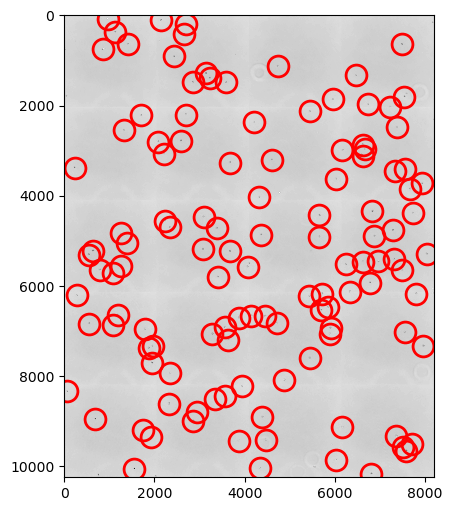

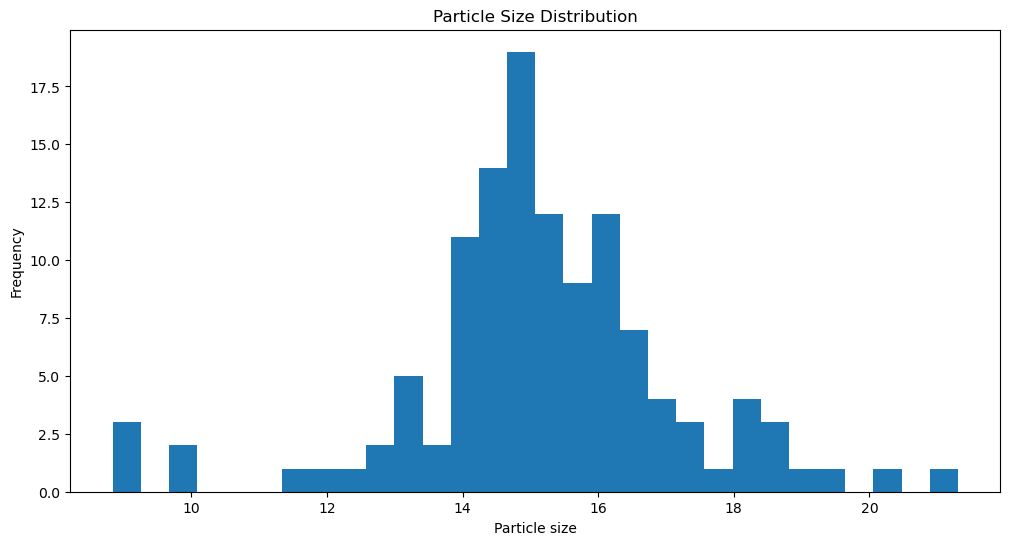

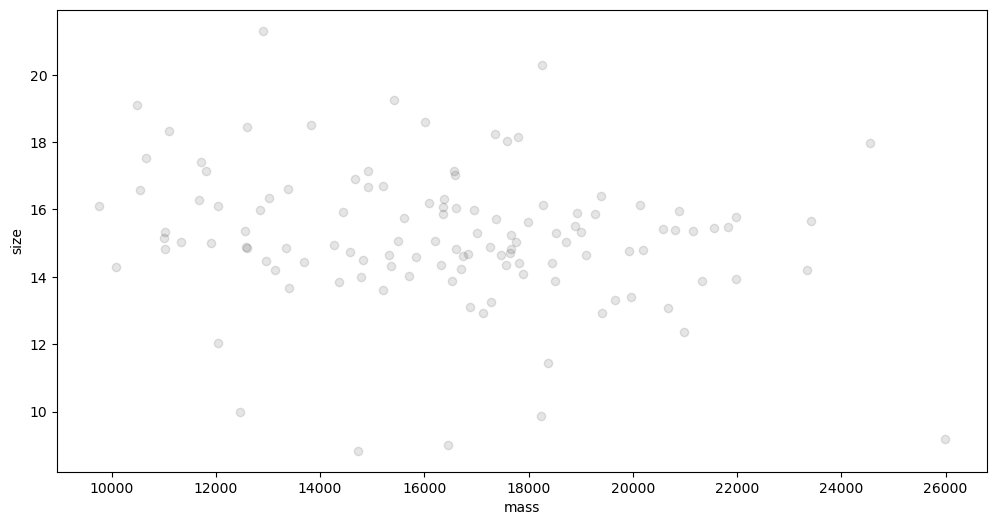

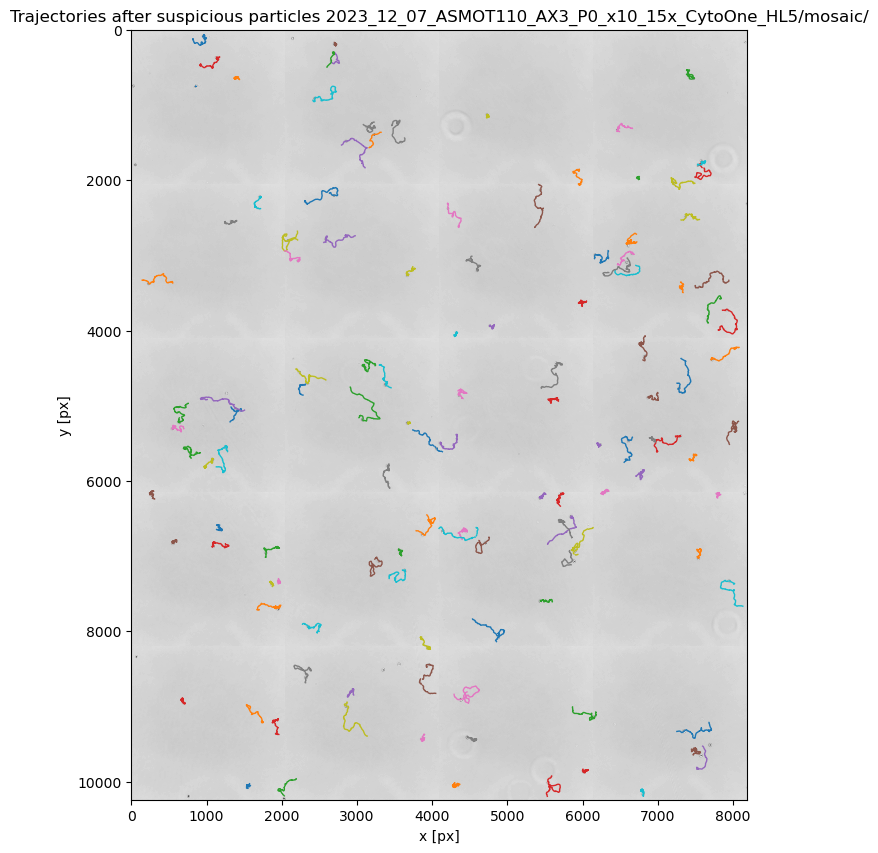

In [14]:
def main():
    """Process all experiments."""
    for exp_name in EXPERIMENT_NAMES:
        print(exp_name)
        process_experiment(exp_name, PARAMS)


if __name__ == '__main__':

    main()